#  AB-Joins for time series comparison

This example is adapted from the [Matrix Profile I](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf) paper, and replicates Figures 9 and 10.

## AB-Joins 

We have already seen that [motifs](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html) (repeating time series patterns) can be identified in a single time series. When calculating the matrix profile of a time series we are analysing it against a duplicate of itself. Moving windows over each copy to calculate the euclidean distances and format a matrix profile. This may also be referred to as a self-join.

The AB-join is an extension of this, where we compare two time series ( _A_ and _B_) to one another. It is performed by the following method:
 - A window of length (m) traverses over _A_, the base time series
 - For each step across _A_ the same length window passes over _B_
 - Each time the euclidean distance is computed
 - A summary matrix profile can be calculated
 
This matrix profile can then be used to identify similarities and differences between time series. 

Fortunately there is no requirement for the time series to be the same length. Though both must have a length greater than or equal to the window length (m).


## Similarities in audio

In this example we are going to look at two songs, whose audio has been converted to Mel Frequency Cepstral  Coefficients (MFCCs). Typically 13 MFCCs construct an audio track, in this instance only a single channel is compared.

The songs are “Under Pressure” by Queen and David Bowie, and “Ice Ice Baby” by Vanilla Ice. For those unfamiliar, Vanilla Ice was alleged to have sampled from "Under Pressure" without crediting the original creators. The copyright claim was later settled out of court. You can hear the similarities in this short [video](https://www.youtube.com/watch?v=HAA__AW3I1M&feature=youtu.be), I'd encourage you to watch the video to contextualise the problem.

## Imports and plot parameters

In [1]:
%matplotlib inline

import stumpy
import pandas as pd
import numpy as np
from zipfile import ZipFile
from io import BytesIO
import os
from urllib.request import urlopen
from scipy.io import loadmat
import matplotlib.pyplot as plt


def change_plot_params(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size
    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['font.size'] = 20
  
    
change_plot_params(20, 6, plt)

## Get the data

In [2]:
#Download the zip from dropbox
fzip = ZipFile(BytesIO(urlopen("https://www.dropbox.com/s/ybzkw5v6h46bv22/figure9_10.zip?dl=1&sa=D&sntz=1&usg=AFQjCNEDp3G8OKGC-Zj5yucpSSCz7WRpRg").read()))
mat = fzip.extract("figure9_10/data.mat")

#Use scipy to convert from Matlab storage to a dict
data = loadmat(mat)

#Place each song in pandas df
queen_df = pd.DataFrame(data['mfcc_queen'][0], columns=['under_pressure'])
vanilla_ice_df = pd.DataFrame(data['mfcc_vanilla_ice'][0], columns=['ice_ice_baby'])

#Remove the download
os.remove(mat)

print("Length of Queen dataset : " , queen_df.size)
print("Length of Vanilla ice dataset : " , vanilla_ice_df.size)

Length of Queen dataset :  24289
Length of Vanilla ice dataset :  23095


## Visualise the MFCCs

Now that we have downloaded the dataset we can plot the 2nd MFCC channel. This data is sampled at 100Hz.

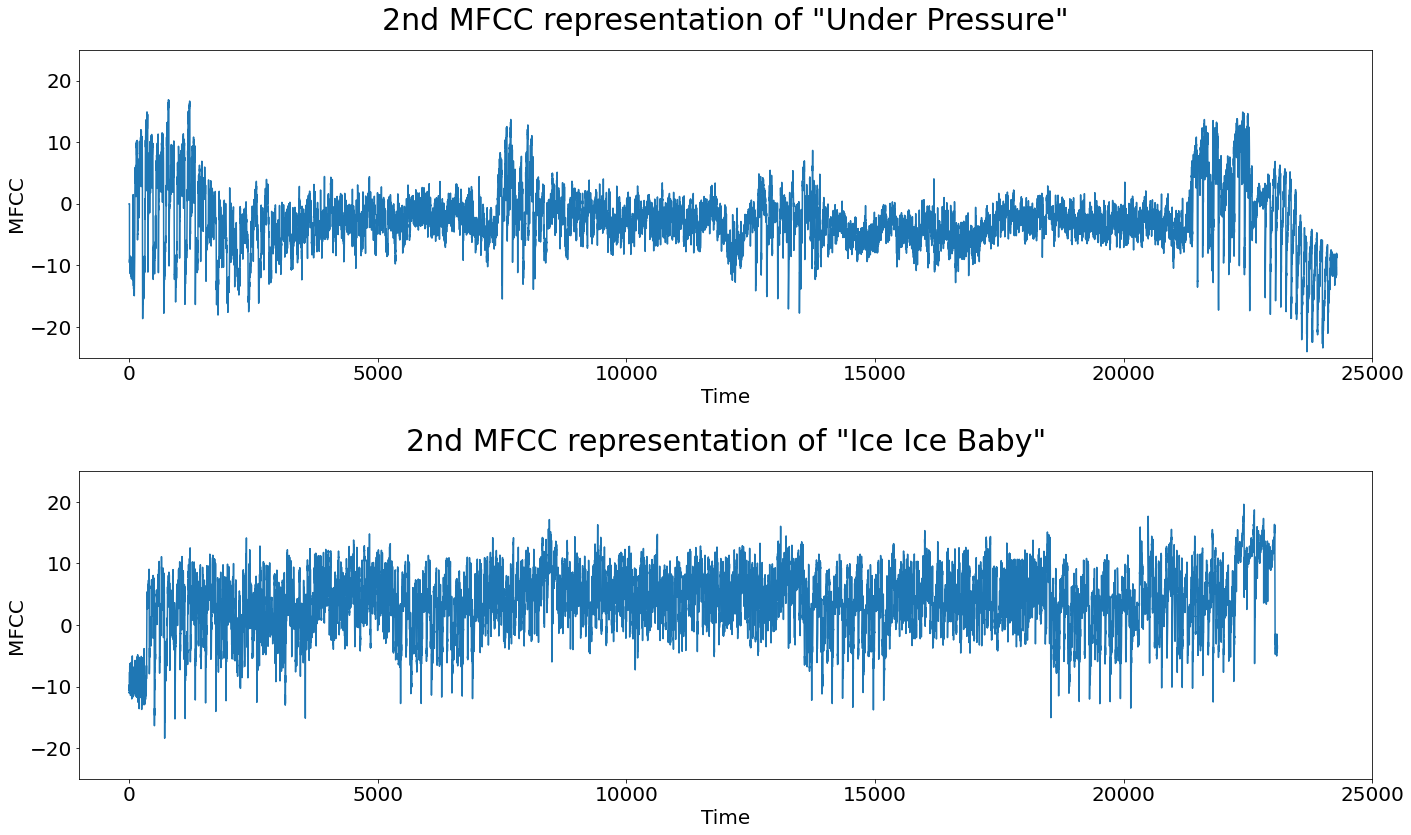

In [3]:
fig, axs = plt.subplots(2, figsize=(20,12))

#Set plot titles
axs[0].set_title('2nd MFCC representation of "Under Pressure"', fontsize = 30, pad = 20)
axs[1].set_title('2nd MFCC representation of "Ice Ice Baby"',  fontsize = 30, pad = 20)

#Set plot x labels 
axs[0].set_xlabel('Time')
axs[1].set_xlabel('Time')

#Set plot y labels 
axs[0].set_ylabel('MFCC')
axs[1].set_ylabel('MFCC')

#Make bounds of x and y same for easier visualisation/comparison
xlim_lower = -1000
xlim_upper = 25000
axs[0].set_xlim(xlim_lower,xlim_upper)
axs[1].set_xlim(xlim_lower,xlim_upper)

ylim_lower = -25
ylim_upper = 25
axs[0].set_ylim(ylim_lower,ylim_upper)
axs[1].set_ylim(ylim_lower,ylim_upper)

#Plot
axs[0].plot(queen_df['under_pressure'])
axs[1].plot(vanilla_ice_df['ice_ice_baby'])

#Stop plot overlaying
plt.tight_layout()

It was very clear in the earlier video that there are strong similarities between the tracks. However even with this prior knowledge it's incredibly difficult to spot the similarities in the data, primarily due to the shear volume of it. 

Fortunately with stumpy we can quickly compute the matrix profile of the two songs through an AB-Join to help us identify and locate this similarity.

## Perform AB-Join 

We calculate the AB-Join matrix profile using `stumpy.stump`, inputting two time series and making sure that the `ignore_trivial =  False `.

We use a window length of 500, as per the original paper.

In [4]:
ab_song_mp = stumpy.stump(T_A = queen_df['under_pressure'], 
                          T_B = vanilla_ice_df['ice_ice_baby'], 
                          m = 500, 
                          ignore_trivial = False)

## Visualise the matrix profile

We can now visualise the matrix profile as we have done for previous problems, looking for maxima and minima. When looking for similar and repeating patterns we look at the lowest matrix profile value. In this case the lowest value appears at index 904, approximately 9 seconds into "Under Pressure".This is shown in the plot below.

Note that the length of the of the matrix profile is dictated by `T_A`.

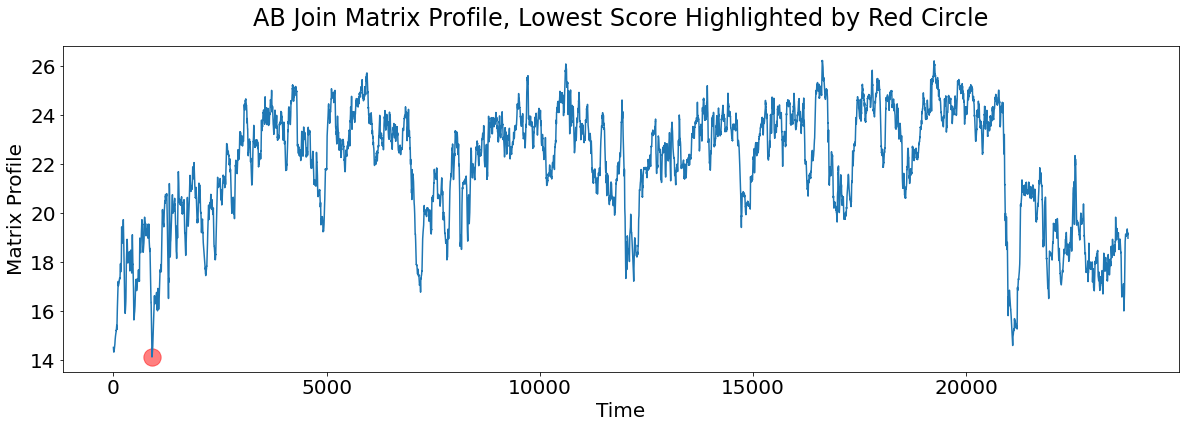

In [5]:
#Find the position of lowest matrix profile value (left most column)
closest_match_loc_queen = ab_song_mp[:,0].argmin()

#Find the lowest matrix profile value (left most column)
lowest_mp_score = ab_song_mp[:,0].min()

#Plot the matrix profile and highlight lowest point
plt.title('AB Join Matrix Profile, Lowest Score Highlighted by Red Circle', pad = 20)
plt.xlabel('Time')
plt.ylabel('Matrix Profile')

#single point scatter of lowest point
plt.scatter(closest_match_loc_queen, lowest_mp_score, 
            c = 'r', alpha = 0.5, s = 300)

#plot matrix profile
plt.plot(ab_song_mp[:,0]);

## Overlay closest matching windows

Through the indexing of the returned array by `stump` we can manipulate each time series to extract the windows
with the strongest match and then lay the MFCC plots over one another for visual comparison. 

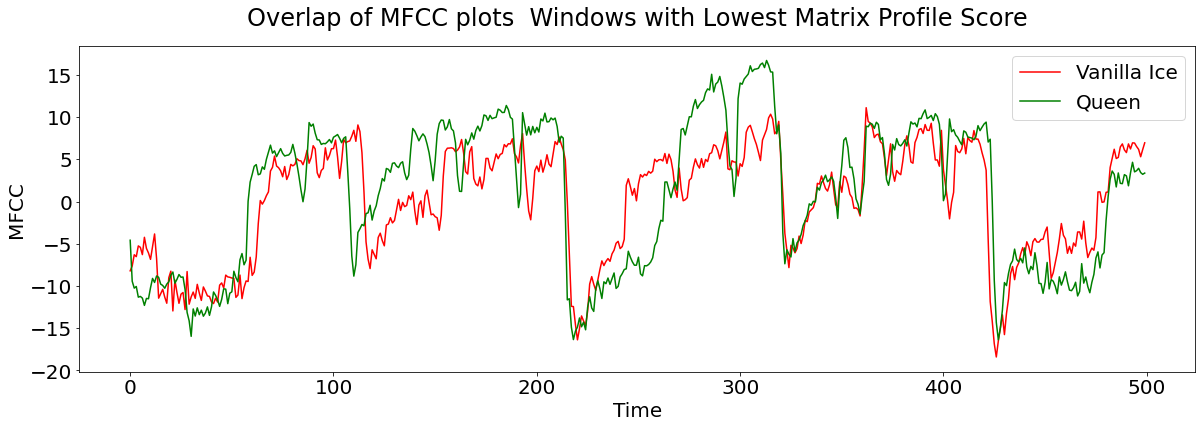

In [6]:
#At the lowest matrix profile value of A, find the corresponding location start point
#In the B profile. This is located in the second column of the stump output (1)
closest_match_loc_vanilla = ab_song_mp[closest_match_loc_queen][1]

#Filter the orignal queen df down to the closest matching window
queen_match_df = queen_df.iloc[closest_match_loc_queen:closest_match_loc_queen+500]

#Filter the orignal vanilla ice df down to the closest matching window
vanilla_match_df = vanilla_ice_df.iloc[closest_match_loc_vanilla:closest_match_loc_vanilla+500]

#Plot using same colour scheme as paper
plt.plot(vanilla_match_df.values, c = 'r', label = 'Vanilla Ice')
plt.plot(queen_match_df.values, c = 'g', label = 'Queen')

#add labels
plt.xlabel('Time')
plt.ylabel('MFCC')

#title
plt.title('Overlap of MFCC plots  Windows with Lowest Matrix Profile Score', pad=20)

#add legend
plt.legend()

plt.show()

The resulting overlay shows really strong correlation between the two segments. Using matrix profiles and stumpy we have been able to identify this in an automated, fast and interpretable fashion. 

This example has focused on audio data but there are many further applications, such as:
- Detecting imminent mechanical issues in sensor data by comparing to known experimental or historical failure datasets
- Find matching movements in commodities or stock prices
- Instead of searching for a minimum value, we could instead find the maximum. With a known healthy dataset we could search for anomalies in another incoming datastream.